In [1]:
# import here
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F

In [2]:
# Load pickled data
training_file = "D:\\MEGA BACKUP\\PC\\Nielit\\gtsrb\\train.p"
validation_file = "D:\\MEGA BACKUP\\PC\\Nielit\\gtsrb\\valid.p"
testing_file = "D:\\MEGA BACKUP\\PC\\Nielit\\gtsrb\\test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [4]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

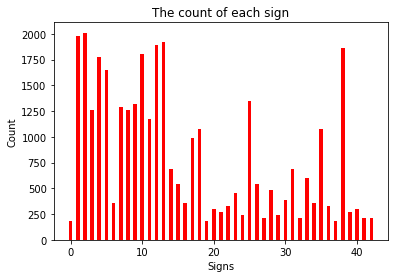

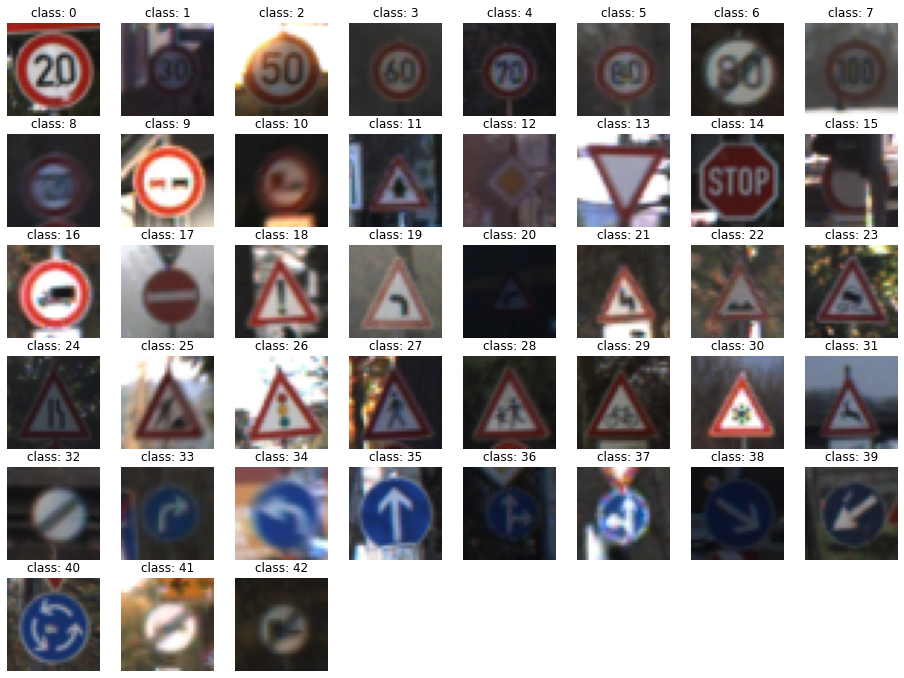

In [5]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

In [6]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [7]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
torch.manual_seed(1)

In [9]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [11]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [12]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)
def fiit(epochs, model, loss_func, opt, train_dl, valid_dl, dl):
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
            test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            test_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Test loss: {test_loss:.6f}\t"
                  f"Test accruacy: {test_accuracy:.3f}%"
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [15]:
fiit(n_epochs, model, criterion, optimizer, train_loader, valid_loader, test_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Test loss: 3.509771	Test accruacy: 6.318%Train loss: 3.675756	Validation loss: 3.592725	 Validation accruacy: 5.510%
[Epoch 2/20] Test loss: 3.476337	Test accruacy: 5.780%Train loss: 3.484531	Validation loss: 3.566735	 Validation accruacy: 5.850%
[Epoch 3/20] Test loss: 3.443507	Test accruacy: 10.602%Train loss: 3.457370	Validation loss: 3.535962	 Validation accruacy: 9.909%
[Epoch 4/20] Test loss: 3.264597	Test accruacy: 17.213%Train loss: 3.343038	Validation loss: 3.342411	 Validation accruacy: 19.093%
[Epoch 5/20] Test loss: 2.344808	Test accruacy: 35.297%Train loss: 2.710284	Validation loss: 2.326005	 Validation accruacy: 36.259%
[Epoch 6/20] Test loss: 1.638526	Test accruacy: 56.429%Train loss: 1.731542	Validation loss: 1.554005	 Validation accruacy: 54.671%
[Epoch 7/20] Test loss: 1.367384	Test accruacy: 66.192%Train loss: 1.152017	Validation loss: 1.176902	 Validation accruacy: 67.256%
[Epoch 8/20] Test loss: 1.272794	Test accruacy: 68.868%Train loss: 0.835714	Valid

In [17]:
Test_loss = [3.509771,3.476337,3.443507,3.264597,2.344808,1.638526,1.367384,1.272794,1.142709,1.117169,0.991350,1.007908,0.996129,0.990292, 0.923320,0.921272,0.937243,0.931465,0.902250,0.942475]
epoch=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

In [17]:
with open('model_pickle','wb') as f:
    pickle.dump(model,f)

In [13]:
import pickle
with open('model_pickle','rb') as f:
    mp = pickle.load(f)

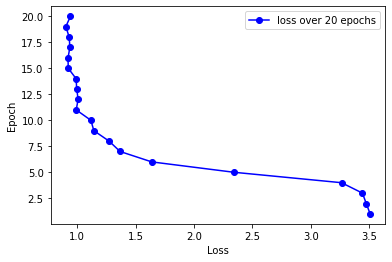

In [18]:
plt.plot(Test_loss,epoch,'b-o',label='loss over 20 epochs');
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend()
plt.show()


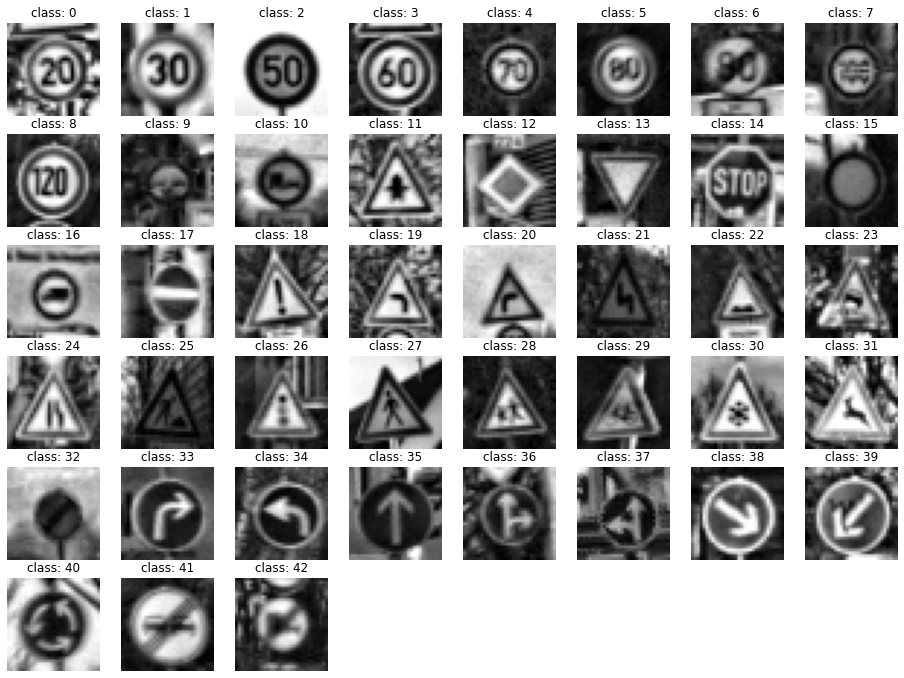

In [14]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [15]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [24]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fiit(n_epochs, model, criterion, optimizer, train_loader, valid_loader, test_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Test loss: 3.487602	Test accruacy: 5.946%Train loss: 3.681444	Validation loss: 3.569368	 Validation accruacy: 5.465%
[Epoch 2/20] Test loss: 3.460745	Test accruacy: 5.701%Train loss: 3.475777	Validation loss: 3.560715	 Validation accruacy: 5.442%
[Epoch 3/20] Test loss: 3.431897	Test accruacy: 6.508%Train loss: 3.455647	Validation loss: 3.524412	 Validation accruacy: 5.556%
[Epoch 4/20] Test loss: 3.118102	Test accruacy: 20.443%Train loss: 3.329808	Validation loss: 3.205184	 Validation accruacy: 18.299%
[Epoch 5/20] Test loss: 1.922260	Test accruacy: 47.340%Train loss: 2.448742	Validation loss: 1.903977	 Validation accruacy: 48.435%
[Epoch 6/20] Test loss: 1.356172	Test accruacy: 61.964%Train loss: 1.405739	Validation loss: 1.203223	 Validation accruacy: 65.782%
[Epoch 7/20] Test loss: 1.198058	Test accruacy: 66.342%Train loss: 0.964305	Validation loss: 0.982005	 Validation accruacy: 70.975%
[Epoch 8/20] Test loss: 0.969637	Test accruacy: 74.561%Train loss: 0.738927	Valida

In [33]:
Test_loss2 = [3.487602,3.460745,3.431897,3.118102,1.922260,1.356172,1.198058,0.969637,0.904229,0.818955,0.803091,0.749072,0.738959,0.728072,0.700556,0.665253,0.683440,0.631554,0.653302,0.660642]
epoch=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

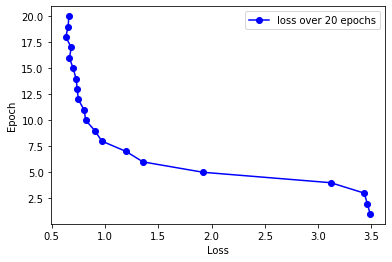

In [34]:
plt.plot(Test_loss2,epoch,'b-o',label='loss over 20 epochs');
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend()
plt.show()


In [36]:
import pickle
with open('model_pickle1','wb') as f:
    pickle.dump(model,f)

In [16]:
import pickle
with open('model_pickle1','rb') as f:
    mp = pickle.load(f)

In [17]:
def preprocess(path):
    if not os.path.exists(f"{path}/train_gray.p"):
        for dataset in ['train', 'valid', 'test']:
            with open(f"{path}/{dataset}.p", mode='rb') as f:
                data = pickle.load(f)
                X = data['features']
                y = data['labels']

            clahe = CLAHE_GRAY()
            for i in range(len(X)):
                X[i] = clahe(X[i])

            X = X[:, :, :, 0]
            with open(f"{path}/{dataset}_gray.p", "wb") as f:
                pickle.dump({"features": X.reshape(
                    X.shape + (1,)), "labels": y}, f)

In [18]:
preprocess('D:\\MEGA BACKUP\\PC\\Nielit\\gtsrb')
training_file = 'D:\\MEGA BACKUP\\PC\\Nielit\\gtsrb\\train_gray.p'
validation_file = "D:\\MEGA BACKUP\\PC\\Nielit\\gtsrb\\valid_gray.p"
testing_file = "D:\\MEGA BACKUP\\PC\\Nielit\\gtsrb\\test_gray.p"

In [19]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

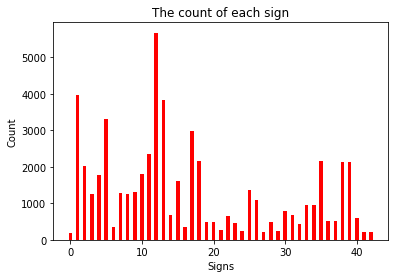

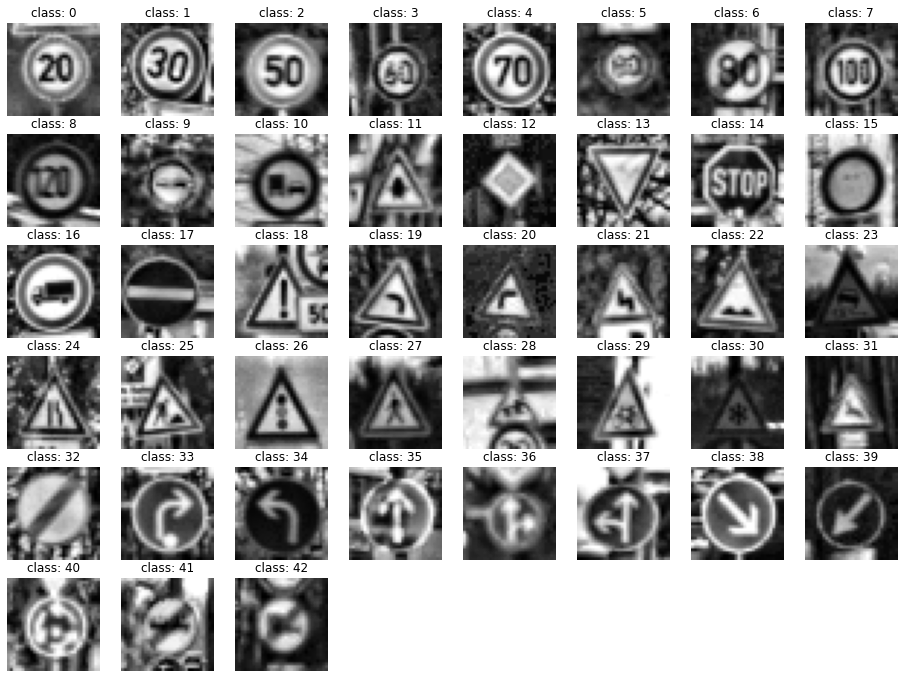

In [20]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i].squeeze(), cmap='gray')

In [42]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fiit(n_epochs, model, criterion, optimizer, train_loader, valid_loader, test_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Test loss: 3.545526	Test accruacy: 5.463%Train loss: 3.553826	Validation loss: 3.633842	 Validation accruacy: 4.762%
[Epoch 2/20] Test loss: 3.328307	Test accruacy: 13.230%Train loss: 3.336291	Validation loss: 3.417162	 Validation accruacy: 11.746%
[Epoch 3/20] Test loss: 1.698942	Test accruacy: 53.088%Train loss: 2.087632	Validation loss: 1.577869	 Validation accruacy: 55.329%
[Epoch 4/20] Test loss: 1.180225	Test accruacy: 67.546%Train loss: 0.984164	Validation loss: 1.000746	 Validation accruacy: 70.930%
[Epoch 5/20] Test loss: 0.987692	Test accruacy: 74.489%Train loss: 0.651806	Validation loss: 0.788463	 Validation accruacy: 77.937%
[Epoch 6/20] Test loss: 0.824676	Test accruacy: 79.074%Train loss: 0.483361	Validation loss: 0.607882	 Validation accruacy: 83.084%
[Epoch 7/20] Test loss: 0.775697	Test accruacy: 80.816%Train loss: 0.381493	Validation loss: 0.535595	 Validation accruacy: 84.830%
[Epoch 8/20] Test loss: 0.714043	Test accruacy: 83.610%Train loss: 0.315742	Va

In [43]:
Test_loss3 = [3.545526,3.328307,1.698942,1.180225,0.987692,0.824676,0.775697,0.714043,0.667964,0.626187,0.585065,0.594630, 0.608713,0.597221,0.582876,0.556315,0.542433,0.500757,0.557533,0.527474]
epoch=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

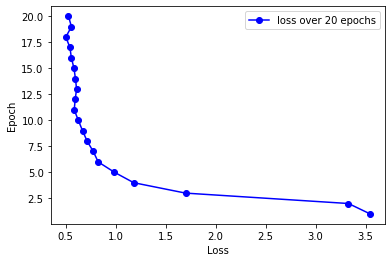

In [44]:
plt.plot(Test_loss3,epoch,'b-o',label='loss over 20 epochs');
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend()
plt.show()


In [45]:
with open('model_pickle2','wb') as f:
    pickle.dump(model,f)

In [21]:
import pickle
with open('model_pickle2','rb') as f:
    mp = pickle.load(f)

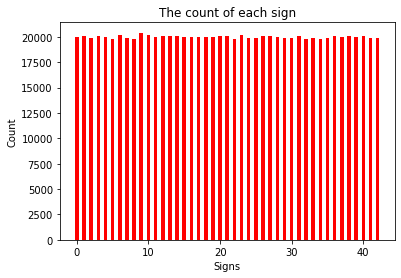

In [22]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 20000)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

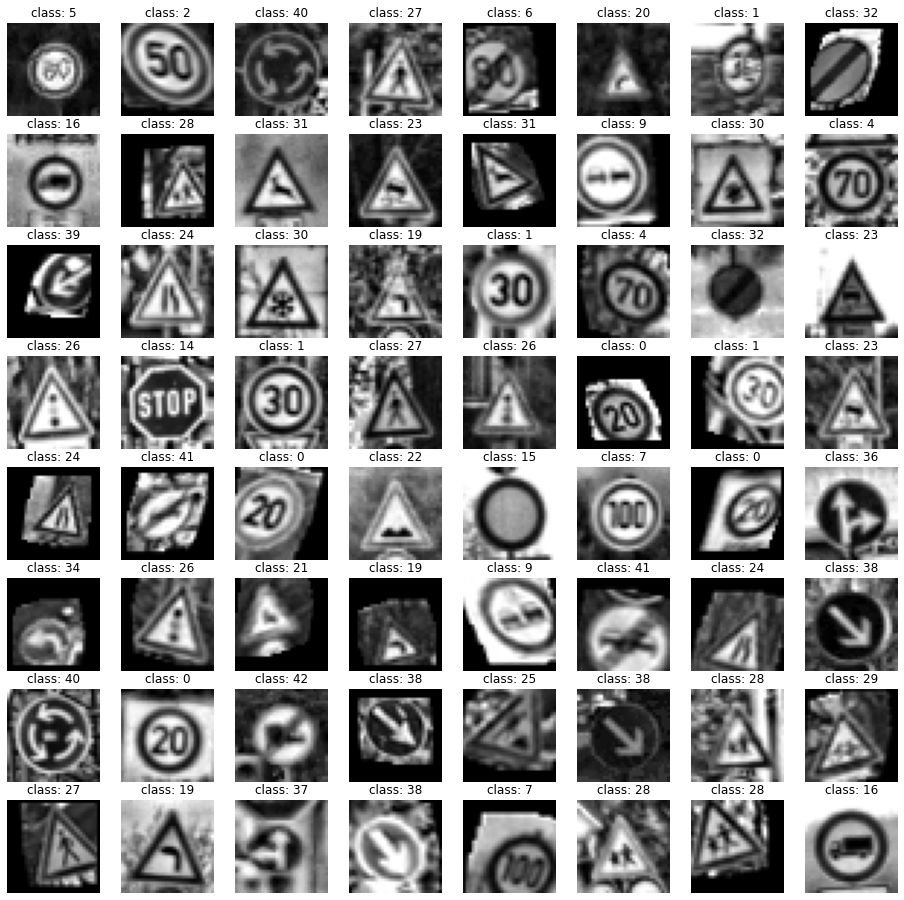

In [23]:

train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.ToTensor()

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [50]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fiit(n_epochs, model, criterion, optimizer, train_loader, valid_loader, test_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Test loss: 0.632292	Test accruacy: 81.362%Train loss: 2.432631	Validation loss: 0.578042	 Validation accruacy: 84.104%
[Epoch 2/20] Test loss: 0.431943	Test accruacy: 87.609%Train loss: 0.782984	Validation loss: 0.351263	 Validation accruacy: 88.844%
[Epoch 3/20] Test loss: 0.402827	Test accruacy: 89.177%Train loss: 0.528707	Validation loss: 0.398044	 Validation accruacy: 89.002%
[Epoch 4/20] Test loss: 0.324025	Test accruacy: 91.259%Train loss: 0.422031	Validation loss: 0.320363	 Validation accruacy: 91.383%
[Epoch 5/20] Test loss: 0.350359	Test accruacy: 91.140%Train loss: 0.364667	Validation loss: 0.370287	 Validation accruacy: 90.839%
[Epoch 6/20] Test loss: 0.314743	Test accruacy: 92.296%Train loss: 0.322183	Validation loss: 0.311187	 Validation accruacy: 93.129%
[Epoch 7/20] Test loss: 0.292829	Test accruacy: 92.470%Train loss: 0.291776	Validation loss: 0.287415	 Validation accruacy: 92.902%
[Epoch 8/20] Test loss: 0.305799	Test accruacy: 92.454%Train loss: 0.269751	

In [51]:
Test_loss4 = [0.632292,0.431943,0.402827,0.324025,0.350359,0.314743,0.292829,0.305799,0.304635,0.271098,0.269342,0.276796,0.271052,0.251686,0.266265,0.275833,0.299649,0.294750,0.295724,0.281509]
epoch=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

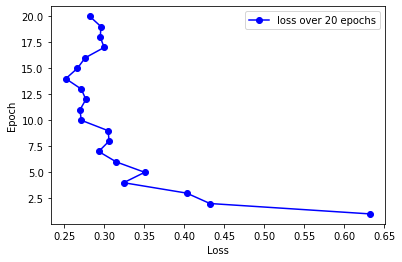

In [52]:
plt.plot(Test_loss4,epoch,'b-o',label='loss over 20 epochs');
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend()
plt.show()

In [53]:
with open('model_pickle3','wb') as f:
    pickle.dump(model,f)

In [24]:
import pickle
with open('model_pickle3','rb') as f:
    mp = pickle.load(f)

In [25]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

In [26]:
n_epochs = 100
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
fiit(n_epochs, model, criterion, optimizer, train_loader, valid_loader,test_loader)

[Epoch 1/100] Test loss: 0.101662	Test accruacy: 96.722%Train loss: 0.673424	Validation loss: 0.087190	 Validation accruacy: 97.732%
[Epoch 2/100] Test loss: 0.070552	Test accruacy: 97.838%Train loss: 0.328254	Validation loss: 0.082673	 Validation accruacy: 98.345%
[Epoch 3/100] Test loss: 0.055609	Test accruacy: 98.266%Train loss: 0.252338	Validation loss: 0.087283	 Validation accruacy: 98.322%
[Epoch 4/100] Test loss: 0.051486	Test accruacy: 98.432%Train loss: 0.212140	Validation loss: 0.074376	 Validation accruacy: 98.526%
[Epoch 5/100] Test loss: 0.049738	Test accruacy: 98.337%Train loss: 0.189922	Validation loss: 0.075788	 Validation accruacy: 98.345%
[Epoch 6/100] Test loss: 0.044414	Test accruacy: 98.662%Train loss: 0.172346	Validation loss: 0.090391	 Validation accruacy: 98.639%
[Epoch 7/100] Test loss: 0.041482	Test accruacy: 98.717%Train loss: 0.159791	Validation loss: 0.077977	 Validation accruacy: 98.435%
[Epoch 8/100] Test loss: 0.044842	Test accruacy: 98.567%Train loss: 0

[Epoch 63/100] Test loss: 0.038692	Test accruacy: 98.899%Train loss: 0.072549	Validation loss: 0.045758	 Validation accruacy: 98.980%
[Epoch 64/100] Test loss: 0.039085	Test accruacy: 98.907%Train loss: 0.072803	Validation loss: 0.057880	 Validation accruacy: 98.798%
[Epoch 65/100] Test loss: 0.033887	Test accruacy: 98.963%Train loss: 0.072262	Validation loss: 0.055108	 Validation accruacy: 98.821%
[Epoch 66/100] Test loss: 0.029871	Test accruacy: 99.137%Train loss: 0.071627	Validation loss: 0.049010	 Validation accruacy: 98.844%
[Epoch 67/100] Test loss: 0.034964	Test accruacy: 98.979%Train loss: 0.070696	Validation loss: 0.047738	 Validation accruacy: 98.776%
[Epoch 68/100] Test loss: 0.034365	Test accruacy: 98.979%Train loss: 0.071613	Validation loss: 0.051327	 Validation accruacy: 98.821%
[Epoch 69/100] Test loss: 0.039735	Test accruacy: 98.725%Train loss: 0.071836	Validation loss: 0.051850	 Validation accruacy: 98.844%
[Epoch 70/100] Test loss: 0.038584	Test accruacy: 98.844%Train

In [28]:
with open('model_pickle4','wb') as f:
    pickle.dump(model,f)

In [29]:
import pickle
with open('model_pickle4','rb') as f:
    mp = pickle.load(f)

In [34]:
class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.ELU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 100),
            nn.ELU(),
            nn.Linear(100, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.stn = Stn()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [36]:
n_epochs=20
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
fiit(n_epochs, model, criterion, optimizer, train_loader, valid_loader,test_loader)

[Epoch 1/20] Test loss: 0.069874	Test accruacy: 97.838%Train loss: 0.474795	Validation loss: 0.084702	 Validation accruacy: 98.050%
[Epoch 2/20] Test loss: 0.048681	Test accruacy: 98.575%Train loss: 0.078650	Validation loss: 0.068684	 Validation accruacy: 98.345%
[Epoch 3/20] Test loss: 0.033374	Test accruacy: 99.169%Train loss: 0.050938	Validation loss: 0.038911	 Validation accruacy: 98.776%
[Epoch 4/20] Test loss: 0.034428	Test accruacy: 99.082%Train loss: 0.039206	Validation loss: 0.049903	 Validation accruacy: 98.639%
[Epoch 5/20] Test loss: 0.036612	Test accruacy: 98.971%Train loss: 0.033809	Validation loss: 0.048766	 Validation accruacy: 98.639%
[Epoch 6/20] Test loss: 0.031348	Test accruacy: 99.042%Train loss: 0.029882	Validation loss: 0.052945	 Validation accruacy: 98.730%
[Epoch 7/20] Test loss: 0.030103	Test accruacy: 99.208%Train loss: 0.026611	Validation loss: 0.035044	 Validation accruacy: 98.821%
[Epoch 8/20] Test loss: 0.034637	Test accruacy: 99.018%Train loss: 0.024183	

In [38]:
evaluate(model, criterion, test_loader)

Test loss: 0.034067	Test accruacy: 99.200%


In [39]:
with open('model_pickle5','wb') as f:
    pickle.dump(model,f)

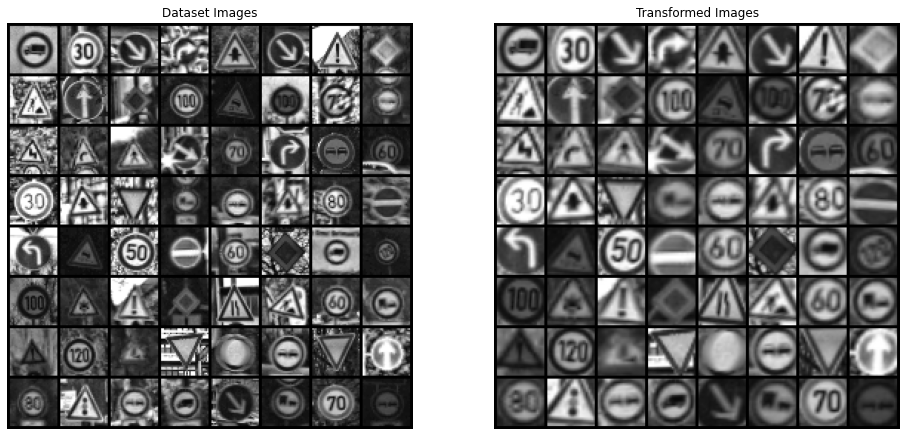

In [40]:
def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
visualize_stn()

In [48]:
import torch
torch.cuda.memory_allocated

<function torch.cuda.memory.memory_allocated(device: Union[torch.device, str, NoneType, int] = None) -> int>

In [49]:
torch.cuda.current_device

<function torch.cuda.current_device() -> int>

In [30]:
!nvidia-smi

Mon Jan 31 13:27:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.76       Driver Version: 496.76       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8     6W /  N/A |   1110MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
plot.subplot(2,1,2)
plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')

NameError: name 'plot' is not defined